SiameseNet Embedding + MLP Classifier


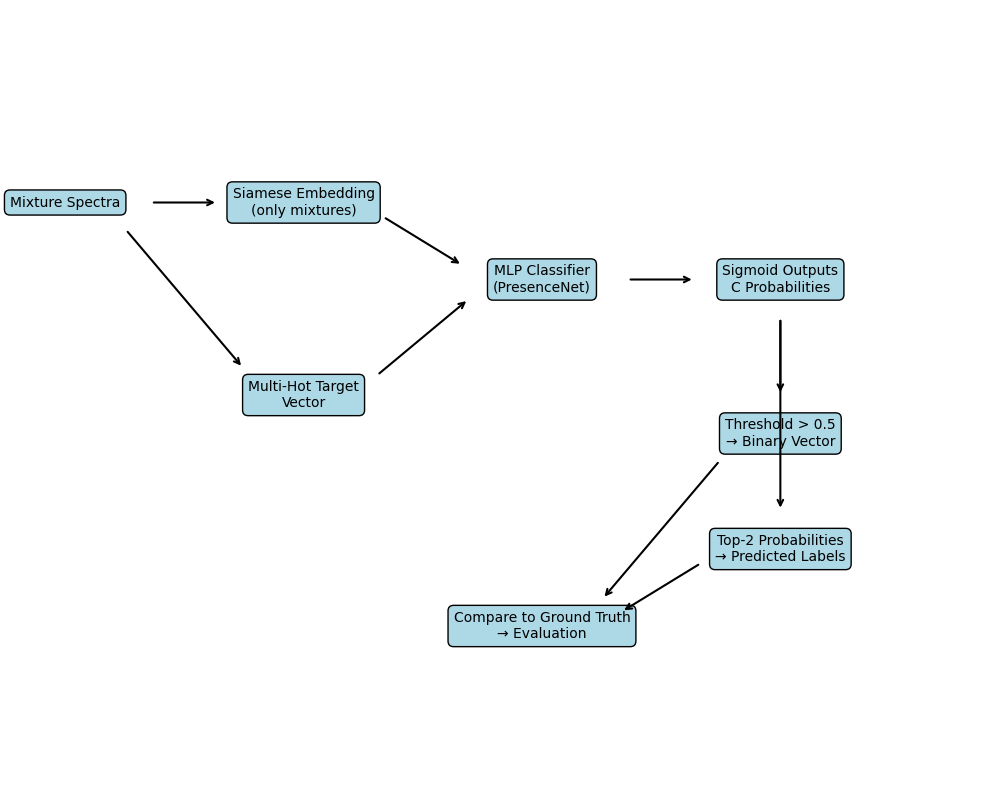

In [11]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')

# Define boxes
boxes = {
    "A": ("Mixture Spectra", (0.05, 0.75)),
    "B": ("Siamese Embedding\n(only mixtures)", (0.3, 0.75)),
    "C": ("Multi-Hot Target\nVector", (0.3, 0.5)),
    "D": ("MLP Classifier\n(PresenceNet)", (0.55, 0.65)),
    "E": ("Sigmoid Outputs\nC Probabilities", (0.8, 0.65)),
    "F": ("Threshold > 0.5\n→ Binary Vector", (0.8, 0.45)),
    "G": ("Top-2 Probabilities\n→ Predicted Labels", (0.8, 0.3)),
    "H": ("Compare to Ground Truth\n→ Evaluation", (0.55, 0.2)),
}

# Box dimensions (in axis fraction space)
box_width = 0.18
box_height = 0.1

# Draw boxes
for key, (text, pos) in boxes.items():
    ax.text(pos[0], pos[1], text,
            bbox=dict(boxstyle="round,pad=0.4", edgecolor='black', facecolor='lightblue'),
            ha='center', va='center', fontsize=10)

# Define arrows between boxes
arrows = [
    ("A", "B"),
    ("A", "C"),
    ("B", "D"),
    ("C", "D"),
    ("D", "E"),
    ("E", "F"),
    ("E", "G"),
    ("F", "H"),
    ("G", "H")
]

# Draw arrows with endpoint adjustment
for src, dst in arrows:
    x1, y1 = boxes[src][1]
    x2, y2 = boxes[dst][1]

    # Direction vector
    dx = x2 - x1
    dy = y2 - y1
    dist = np.hypot(dx, dy)
    if dist == 0:
        continue
    dx /= dist
    dy /= dist

    # Apply offset to avoid overlapping boxes
    offset_x = dx * box_width / 2
    offset_y = dy * box_height / 2

    start = (x1 + offset_x, y1 + offset_y)
    end = (x2 - offset_x, y2 - offset_y)

    ax.annotate("",
                xy=end, xycoords='axes fraction',
                xytext=start, textcoords='axes fraction',
                arrowprops=dict(arrowstyle="->", lw=1.5))

plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
import numpy as npo
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
mix_df = pd.read_csv('mixtures_dataset.csv')
print("First rows of raw mixture data:")
print(mix_df.head(), "\n")

First rows of raw mixture data:
       188  190.2160313  192.4320626  194.6480938  196.8641251  199.0801564  \
0  318.889   307.785419   296.595144   291.167280   286.469061   277.177431   
1  302.222   295.766457   286.192633   277.160495   270.104620   266.691403   
2  301.778   294.934926   286.238640   279.353855   273.163039   265.388584   
3  306.222   297.958951   290.939337   285.278529   273.979631   269.807826   
4  302.444   291.985915   284.926593   282.108512   272.712430   267.592604   

   201.2961877  203.512219  205.7282502  207.9442815  ...  2439.487781  \
0   268.440870  260.332805   259.164559   256.145239  ...   191.540098   
1   261.577900  257.076653   251.471106   245.386480  ...   191.120504   
2   257.416904  249.443805   244.314872   243.541740  ...   188.495938   
3   265.442935  258.578653   253.400572   250.418422  ...   184.215622   
4   259.074166  257.556000   250.377079   246.313404  ...   194.080596   

   2441.703812  2443.919844  2446.135875  2448.3

In [53]:
def floatify_cols(df):
    new_cols = []
    for c in df.columns:
        # Keep any of the exact label columns unchanged
        if c in ('Label', 'Label 1', 'Label 2'):
            new_cols.append(c)
        else:
            # Convert wavenumber strings to floats
            new_cols.append(float(c))
    df.columns = new_cols

floatify_cols(mix_df)
print("Columns after floatify (first 10):")
print(list(mix_df.columns[:10]), "\n")

Columns after floatify (first 10):
[188.0, 190.2160313, 192.4320626, 194.6480938, 196.8641251, 199.0801564, 201.2961877, 203.512219, 205.7282502, 207.9442815] 



In [17]:
# 3) Identify wavenumber columns
wav_cols = [c for c in mix_df.columns if c not in ('Label 1', 'Label 2')]
print(f"Number of wavenumber columns: {len(wav_cols)}")
print("Example wavenumbers:", wav_cols[:5], "\n")
# 4) Extract and preprocess spectra
mix_specs = mix_df[wav_cols].values
print("Raw spectra array shape:", mix_specs.shape)

# Preprocessing functions (AsLS + L2 norm)
lam, p, niter = 1e4, 0.01, 10
def baseline_als(y):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, s in enumerate(arr):
        b = baseline_als(s)
        c = s - b
        norm = np.linalg.norm(c)
        out[i] = c / norm if norm > 0 else c
    return out

mix_proc = preprocess(mix_specs)
print("Preprocessed spectra shape:", mix_proc.shape, "\n")

Number of wavenumber columns: 1024
Example wavenumbers: [188.0, 190.2160313, 192.4320626, 194.6480938, 196.8641251] 

Raw spectra array shape: (580, 1024)
Preprocessed spectra shape: (580, 1024) 



In [63]:
class SiameseNet(nn.Module):
    def __init__(self, input_len, embed_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_len // 4) * 32, embed_dim),
            nn.ReLU()
        )
    def forward(self, x):
        z = self.encoder(x)
        return F.normalize(z, dim=1)
        
model = SiameseNet(input_len=mix_proc.shape[1], embed_dim=64)
model.load_state_dict(torch.load('siamese_raman_resampled.pth', map_location='cpu'))
model.eval()

with torch.no_grad():
    mix_tensor = torch.tensor(mix_proc, dtype=torch.float32).unsqueeze(1)
    mix_embeds = model(mix_tensor).cpu().numpy()
print("Mixture embeddings shape:", mix_embeds.shape, "\n")

Mixture embeddings shape: (580, 64) 



In [26]:
# 6) Build multi-hot target vectors
labels1 = mix_df['Label 1'].values
labels2 = mix_df['Label 2'].values
# Determine unique classes from both Label 1 and Label 2
classes = sorted(set(labels1) | set(labels2))
print("Identified classes:", classes, "\n")

Identified classes: ['1-dodecanethiol', '6-mercapto-1-hexanol', 'benzene', 'benzenethiol', 'etoh', 'meoh', 'n,n-dimethylformamide', 'pyridine'] 



In [30]:

# Map each class to an index
class_to_idx = {c: i for i, c in enumerate(classes)}

# Initialize multi-hot matrix
multi_hot = np.zeros((len(mix_df), len(classes)), dtype=int)

# Populate multi-hot vectors
for i, (l1, l2) in enumerate(zip(labels1, labels2)):
    multi_hot[i, class_to_idx[l1]] = 1
    if pd.notna(l2):
        multi_hot[i, class_to_idx[l2]] = 1

print("Multi-hot targets shape:", multi_hot.shape)
print("First 5 multi-hot vectors:\n", multi_hot[:5])

Multi-hot targets shape: (580, 8)
First 5 multi-hot vectors:
 [[0 1 1 0 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 1 1 0 0 0 0 0]]


In [31]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [34]:
X = torch.tensor(mix_embeds, dtype=torch.float32)
Y = torch.tensor(multi_hot, dtype=torch.float32)

X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# 2) Split the remaining 75% into train (2/3 of remaining = 50% total) and validation (1/3 of remaining = 25% total)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=1/3, random_state=42)

# Verify sizes
print(f"Total samples: {len(X)}")
print(f"Train set:      {len(X_train)} ({len(X_train)/len(X):.0%})")
print(f"Validation set: {len(X_val)} ({len(X_val)/len(X):.0%})")
print(f"Test set:       {len(X_test)} ({len(X_test)/len(X):.0%})")

Total samples: 580
Train set:      290 (50%)
Validation set: 145 (25%)
Test set:       145 (25%)


In [35]:
batch_size = 32
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(Y_train, dtype=torch.float32)),
                          batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(torch.tensor(X_val,   dtype=torch.float32),
                                        torch.tensor(Y_val,   dtype=torch.float32)),
                          batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(torch.tensor(X_test,  dtype=torch.float32),
                                        torch.tensor(Y_test,  dtype=torch.float32)),
                          batch_size=batch_size)

C:\Users\levinej\AppData\Local\Temp\ipykernel_15412\890566446.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
C:\Users\levinej\AppData\Local\Temp\ipykernel_15412\890566446.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(Y_train, dtype=torch.float32)),
C:\Users\levinej\AppData\Local\Temp\ipykernel_15412\890566446.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loader   = DataLoader(TensorDataset(torch.tensor(X_val,   dtype=torch

In [38]:
class PresenceNet(nn.Module):
    def __init__(self,input_dim,num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

In [57]:
D = mix_embeds.shape[1]
C = multi_hot.shape[1]
model_MLP = PresenceNet(input_dim=D, num_classes=C)
print(model_MLP)

PresenceNet(
  (net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): Sigmoid()
  )
)


In [58]:
# 4) Training setup (unchanged)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_MLP.parameters(), lr=1e-3)
num_epochs = 50

In [59]:
# 5) Training loop with validation (unchanged)
for epoch in range(num_epochs):
    model_MLP.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        preds = model_MLP(xb)
        loss  = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    train_loss = total_loss / len(train_loader.dataset)

    model_MLP.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            val_loss += criterion(model_MLP(xb), yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/50 — Train Loss: 0.7030 | Val Loss: 0.6979
Epoch 2/50 — Train Loss: 0.6928 | Val Loss: 0.6870
Epoch 3/50 — Train Loss: 0.6806 | Val Loss: 0.6724
Epoch 4/50 — Train Loss: 0.6623 | Val Loss: 0.6504
Epoch 5/50 — Train Loss: 0.6342 | Val Loss: 0.6176
Epoch 6/50 — Train Loss: 0.5961 | Val Loss: 0.5767
Epoch 7/50 — Train Loss: 0.5503 | Val Loss: 0.5353
Epoch 8/50 — Train Loss: 0.5104 | Val Loss: 0.5042
Epoch 9/50 — Train Loss: 0.4804 | Val Loss: 0.4817
Epoch 10/50 — Train Loss: 0.4588 | Val Loss: 0.4613
Epoch 11/50 — Train Loss: 0.4384 | Val Loss: 0.4422
Epoch 12/50 — Train Loss: 0.4201 | Val Loss: 0.4244
Epoch 13/50 — Train Loss: 0.4029 | Val Loss: 0.4068
Epoch 14/50 — Train Loss: 0.3865 | Val Loss: 0.3922
Epoch 15/50 — Train Loss: 0.3730 | Val Loss: 0.3794
Epoch 16/50 — Train Loss: 0.3612 | Val Loss: 0.3677
Epoch 17/50 — Train Loss: 0.3507 | Val Loss: 0.3563
Epoch 18/50 — Train Loss: 0.3407 | Val Loss: 0.3470
Epoch 19/50 — Train Loss: 0.3315 | Val Loss: 0.3375
Epoch 20/50 — Train L

In [60]:
# 6) Evaluate on Validation Set
all_val_preds, all_val_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        all_val_preds.append(model_MLP(xb).numpy())
        all_val_true.append(yb.numpy())

y_val_true = np.vstack(all_val_true)
y_val_pred = (np.vstack(all_val_preds) > 0.5).astype(int)
print("\nValidation Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=classes))


Validation Classification Report:
                       precision    recall  f1-score   support

      1-dodecanethiol       1.00      0.69      0.82        55
 6-mercapto-1-hexanol       0.40      0.27      0.32        30
              benzene       1.00      1.00      1.00        45
         benzenethiol       0.00      0.00      0.00        16
                 etoh       1.00      0.70      0.82        33
                 meoh       0.87      0.88      0.88        60
n,n-dimethylformamide       1.00      1.00      1.00        20
             pyridine       1.00      1.00      1.00        31

            micro avg       0.92      0.75      0.83       290
            macro avg       0.78      0.69      0.73       290
         weighted avg       0.86      0.75      0.79       290
          samples avg       0.94      0.75      0.81       290



c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [61]:
# ——— NEW: 7) Final Evaluation on Test Set ———
all_test_preds, all_test_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        all_test_preds.append(model_MLP(xb).numpy())
        all_test_true.append(yb.numpy())

y_test_true = np.vstack(all_test_true)
y_test_pred = (np.vstack(all_test_preds) > 0.5).astype(int)
print("\nTest Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=classes))


Test Classification Report:
                       precision    recall  f1-score   support

      1-dodecanethiol       1.00      0.57      0.72        60
 6-mercapto-1-hexanol       0.62      0.33      0.43        24
              benzene       1.00      1.00      1.00        62
         benzenethiol       0.00      0.00      0.00        26
                 etoh       1.00      0.72      0.84        29
                 meoh       0.84      0.82      0.83        56
n,n-dimethylformamide       1.00      1.00      1.00        13
             pyridine       1.00      1.00      1.00        20

            micro avg       0.94      0.70      0.80       290
            macro avg       0.81      0.68      0.73       290
         weighted avg       0.85      0.70      0.76       290
          samples avg       0.96      0.70      0.79       290



c:\Users\levinej\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [66]:
# ─── 1) LOAD & PREPROCESS REFERENCE_V2 (many per class) ────────────────────────
ref_df = pd.read_csv('reference_v2.csv')

# Convert the column names to floats (wavenumbers)
floatify_cols(ref_df)

# Identify wavenumber columns (everything except 'Label')
wav_cols = [c for c in ref_df.columns if c != 'Label']

# Extract raw spectra and labels
ref_specs  = ref_df[wav_cols].values       # shape: (n_ref_samples, n_wavenumbers)
ref_labels = ref_df['Label'].values        # length: n_ref_samples
true_pairs = list(zip(mix_df['Label 1'], mix_df['Label 2']))  # <— and this

In [55]:
# Preprocess all reference spectra
ref_proc = preprocess(ref_specs)           # same AsLS + L2 pipeline
print("Loaded & preprocessed reference_v2:", ref_proc.shape, "samples,", len(np.unique(ref_labels)), "classes")

Loaded & preprocessed reference_v2: (565, 1024) samples, 12 classes


In [64]:
# ─── 2) EMBED ALL REFERENCE SPECTRA ────────────────────────────────────────────
with torch.no_grad():
    ref_tensor  = torch.tensor(ref_proc, dtype=torch.float32).unsqueeze(1)  # (n_ref, 1, n_waves)
    pure_embeds = model(ref_tensor).cpu().numpy()                          # (n_ref, D)
print("Pure embeddings from reference_v2:", pure_embeds.shape)

Pure embeddings from reference_v2: (565, 64)


In [68]:
# ─── 4) Build combined dataset ─────────────────────────────────────────────────
# classes & index map
classes     = sorted(set(ref_labels) | {lbl for pair in true_pairs for lbl in pair})
class_to_i  = {c:i for i,c in enumerate(classes)}
C           = len(classes)

In [69]:
# Stack embeddings
X_all = np.vstack([pure_embeds, mix_embeds])

# Build Y_all
Y_all = np.zeros((len(X_all), C), dtype=int)
# pure one-hot
for i, lab in enumerate(ref_labels):
    Y_all[i, class_to_i[lab]] = 1
# mixture two-hot
offset = len(ref_labels)
for i, (l1, l2) in enumerate(true_pairs):
    Y_all[offset+i, class_to_i[l1]] = 1
    if pd.notna(l2):
        Y_all[offset+i, class_to_i[l2]] = 1

print("X_all:", X_all.shape, "Y_all:", Y_all.shape)

X_all: (1145, 64) Y_all: (1145, 12)


In [70]:
X_tmp, X_test, Y_tmp, Y_test = train_test_split(X_all, Y_all, test_size=0.25, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_tmp, Y_tmp, test_size=1/3, random_state=42)
print("Train/Val/Test:", len(X_train), len(X_val), len(X_test))

Train/Val/Test: 572 286 287


In [71]:
# ─── 6) DataLoaders ───────────────────────────────────────────────────────────
batch_size = 32
train_loader = DataLoader(TensorDataset(torch.tensor(X_train,dtype=torch.float32),
                                        torch.tensor(Y_train,dtype=torch.float32)),
                          batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(torch.tensor(X_val,  dtype=torch.float32),
                                        torch.tensor(Y_val,  dtype=torch.float32)),
                          batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                        torch.tensor(Y_test, dtype=torch.float32)),
                          batch_size=batch_size)

In [72]:
class PresenceNet(nn.Module):
    def __init__(self, D, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(D, 64), nn.ReLU(),
            nn.Linear(64,32),  nn.ReLU(),
            nn.Linear(32, C),  nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

D = X_all.shape[1]
model_presence = PresenceNet(D, C)
print(model_presence)

PresenceNet(
  (net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=12, bias=True)
    (5): Sigmoid()
  )
)


In [74]:
# ─── 8) Train / Validate ──────────────────────────────────────────────────────
criterion = nn.BCELoss()
optimizer = optim.Adam(model_presence.parameters(), lr=1e-3)
epochs    = 50

In [75]:
for e in range(1, epochs+1):
    model_presence.train()
    tloss = 0
    for xb, yb in train_loader:
        pred = model_presence(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        tloss += loss.item()*xb.size(0)
    tloss /= len(train_loader.dataset)

    model_presence.eval()
    vloss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            vloss += criterion(model_presence(xb), yb).item()*xb.size(0)
    vloss /= len(val_loader.dataset)

    print(f"Epoch {e}/{epochs} - Train Loss: {tloss:.4f}, Val Loss: {vloss:.4f}")

Epoch 1/50 - Train Loss: 0.6839, Val Loss: 0.6657
Epoch 2/50 - Train Loss: 0.6408, Val Loss: 0.6048
Epoch 3/50 - Train Loss: 0.5539, Val Loss: 0.4845
Epoch 4/50 - Train Loss: 0.4219, Val Loss: 0.3626
Epoch 5/50 - Train Loss: 0.3428, Val Loss: 0.3298
Epoch 6/50 - Train Loss: 0.3276, Val Loss: 0.3223
Epoch 7/50 - Train Loss: 0.3213, Val Loss: 0.3173
Epoch 8/50 - Train Loss: 0.3155, Val Loss: 0.3116
Epoch 9/50 - Train Loss: 0.3083, Val Loss: 0.3038
Epoch 10/50 - Train Loss: 0.2992, Val Loss: 0.2940
Epoch 11/50 - Train Loss: 0.2878, Val Loss: 0.2827
Epoch 12/50 - Train Loss: 0.2749, Val Loss: 0.2705
Epoch 13/50 - Train Loss: 0.2613, Val Loss: 0.2583
Epoch 14/50 - Train Loss: 0.2489, Val Loss: 0.2472
Epoch 15/50 - Train Loss: 0.2368, Val Loss: 0.2376
Epoch 16/50 - Train Loss: 0.2265, Val Loss: 0.2285
Epoch 17/50 - Train Loss: 0.2174, Val Loss: 0.2199
Epoch 18/50 - Train Loss: 0.2089, Val Loss: 0.2115
Epoch 19/50 - Train Loss: 0.2009, Val Loss: 0.2033
Epoch 20/50 - Train Loss: 0.1932, Val Lo

In [84]:
# ─── Validation Set Evaluation ─────────────────────────────────────────────────
model_presence.eval()
vp, vt = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        vp.append(model_presence(xb).numpy())
        vt.append(yb.numpy())

y_val_pred = (np.vstack(vp) > 0.5).astype(int)
y_val_true = np.vstack(vt)

print("\nValidation Set Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=classes, zero_division=0))

# ─── Test Set Evaluation (as before) ───────────────────────────────────────────
model_presence.eval()
tp, tt = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        tp.append(model_presence(xb).numpy())
        tt.append(yb.numpy())

y_test_pred = (np.vstack(tp) > 0.5).astype(int)
y_test_true = np.vstack(tt)

print("\nTest Set Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=classes, zero_division=0))



Validation Set Classification Report:
                              precision    recall  f1-score   support

           1,9-nonanedithiol       0.00      0.00      0.00        11
             1-dodecanethiol       0.79      0.62      0.70        72
             1-undecanethiol       0.00      0.00      0.00         7
        6-mercapto-1-hexanol       1.00      0.57      0.73        28
                     benzene       1.00      1.00      1.00        59
                benzenethiol       0.00      0.00      0.00        20
                        dmmp       1.00      1.00      1.00         7
                        etoh       1.00      0.76      0.86        54
                        meoh       0.92      0.93      0.92       110
       n,n-dimethylformamide       1.00      1.00      1.00        28
                    pyridine       1.00      1.00      1.00        36
tris(2-ethylhexyl) phosphate       0.00      0.00      0.00         5

                   micro avg       0.94      0.76

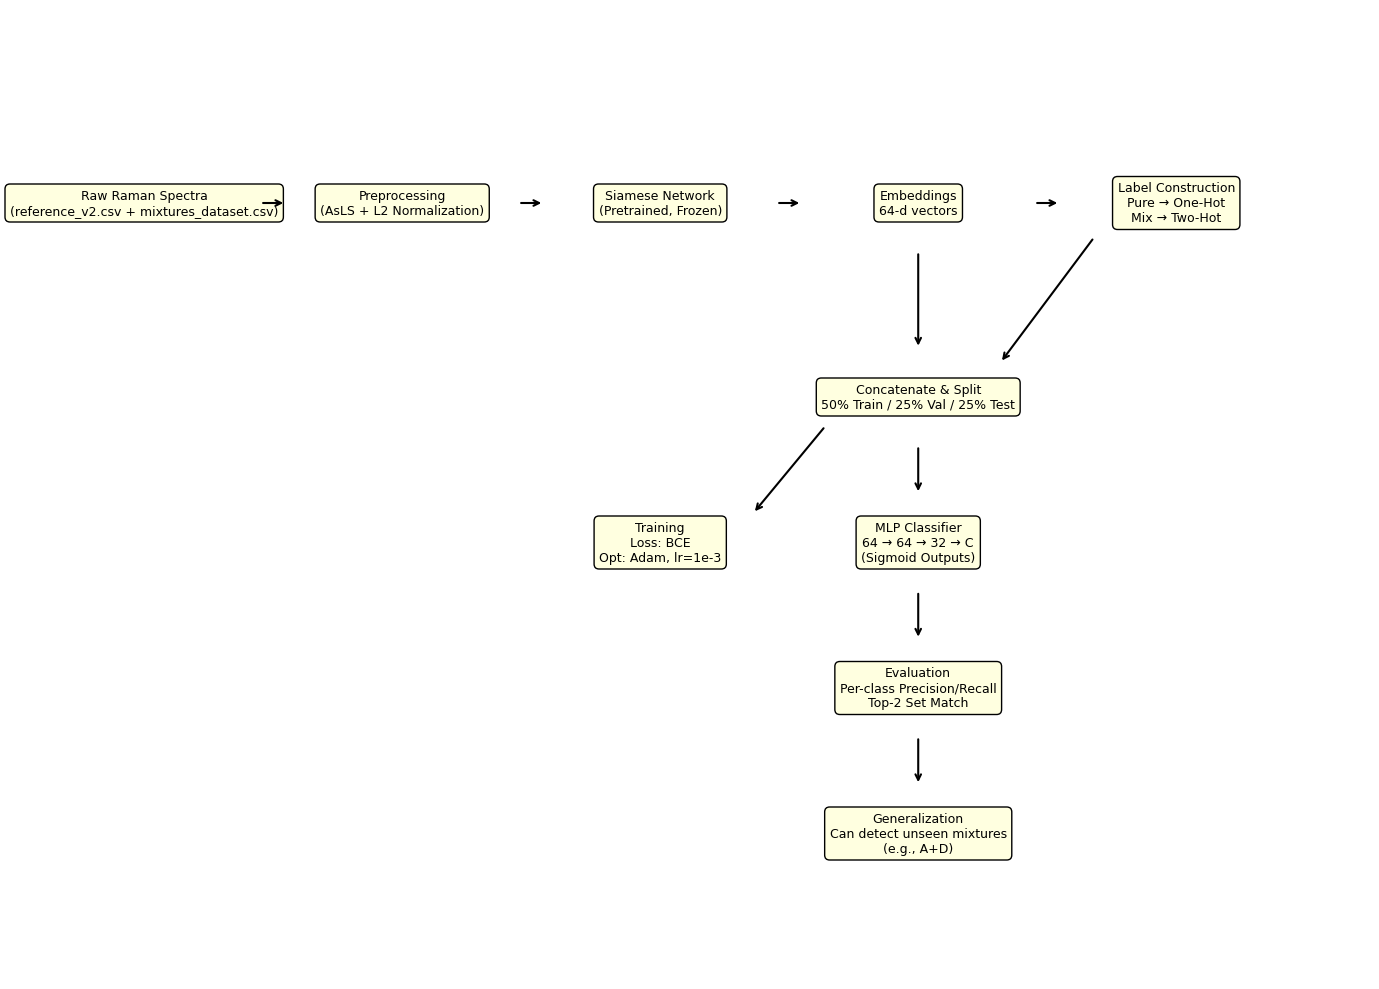

In [81]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('off')

# New positions for a clearer layout
boxes = {
    "1": ("Raw Raman Spectra\n(reference_v2.csv + mixtures_dataset.csv)", (0.05, 0.8)),
    "2": ("Preprocessing\n(AsLS + L2 Normalization)", (0.25, 0.8)),
    "3": ("Siamese Network\n(Pretrained, Frozen)", (0.45, 0.8)),
    "4": ("Embeddings\n64-d vectors", (0.65, 0.8)),
    "5": ("Label Construction\nPure → One-Hot\nMix → Two-Hot", (0.85, 0.8)),
    "6": ("Concatenate & Split\n50% Train / 25% Val / 25% Test", (0.65, 0.6)),
    "7": ("MLP Classifier\n64 → 64 → 32 → C\n(Sigmoid Outputs)", (0.65, 0.45)),
    "8": ("Training\nLoss: BCE\nOpt: Adam, lr=1e-3", (0.45, 0.45)),
    "9": ("Evaluation\nPer-class Precision/Recall\nTop-2 Set Match", (0.65, 0.3)),
    "10": ("Generalization\nCan detect unseen mixtures\n(e.g., A+D)", (0.65, 0.15)),
}

# Draw the boxes
for key, (text, pos) in boxes.items():
    ax.text(pos[0], pos[1], text,
            bbox=dict(boxstyle="round,pad=0.4", edgecolor='black', facecolor='lightyellow'),
            ha='center', va='center', fontsize=9)

# Define arrows between logical flow steps
arrows = [
    ("1", "2"),
    ("2", "3"),
    ("3", "4"),
    ("4", "5"),
    ("4", "6"),
    ("5", "6"),
    ("6", "7"),
    ("6", "8"),
    ("7", "9"),
    ("9", "10")
]

# Define box size for offset calculation
box_width = 0.18
box_height = 0.1

# Draw arrows with adjusted endpoints
for src, dst in arrows:
    x1, y1 = boxes[src][1]
    x2, y2 = boxes[dst][1]

    dx = x2 - x1
    dy = y2 - y1
    dist = np.hypot(dx, dy)
    if dist == 0:
        continue
    dx /= dist
    dy /= dist

    x_offset = dx * box_width / 2
    y_offset = dy * box_height / 2

    start = (x1 + x_offset, y1 + y_offset)
    end = (x2 - x_offset, y2 - y_offset)

    ax.annotate("",
                xy=end, xycoords='axes fraction',
                xytext=start, textcoords='axes fraction',
                arrowprops=dict(arrowstyle="->", lw=1.5))

plt.tight_layout()
plt.show()


In [85]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader

In [86]:
# ─── Utilities ────────────────────────────────────────────────────────────────
lam, p, niter = 1e4, 0.01, 10
def baseline_als(y):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr):
    out = np.zeros_like(arr)
    for i, s in enumerate(arr):
        b = baseline_als(s)
        c = s - b
        norm = np.linalg.norm(c)
        out[i] = c / norm if norm > 0 else c
    return out

def floatify_cols(df):
    new = []
    for c in df.columns:
        if c in ('Label', 'Label 1', 'Label 2'):
            new.append(c)
        else:
            new.append(float(c))
    df.columns = new

In [87]:
# ─── 1) Load reference_v2 and preprocess ──────────────────────────────────────
ref_df = pd.read_csv('reference_v2.csv')

floatify_cols(ref_df)
wav_cols = [c for c in ref_df.columns if c != 'Label']
ref_specs  = ref_df[wav_cols].values       # (n_ref_samples, n_waves)
ref_labels = ref_df['Label'].values        # (n_ref_samples,)
ref_proc   = preprocess(ref_specs)         # (n_ref_samples, n_waves)

In [173]:
ref_specs.shape[1]

1024

In [90]:
# Unique chemical classes
classes    = sorted(np.unique(ref_labels))
C = len(classes)
class_to_i = {c:i for i,c in enumerate(classes)}

# ─── 2) Generate synthetic mixtures ────────────────────────────────────────────
ratios = np.arange(0.05, 1.0, 0.05)
noise_level = 0.01
n_per_ratio = 10  # number of random spectra per pair/ratio

synth_specs = []
synth_labels = []
for (i, ci), (j, cj) in combinations(enumerate(classes), 2):
    # indices of pure spectra for each class
    idx_i = np.where(ref_labels == ci)[0]
    idx_j = np.where(ref_labels == cj)[0]
    for r in ratios:
        for _ in range(n_per_ratio):
            spec_i = ref_specs[np.random.choice(idx_i)]
            spec_j = ref_specs[np.random.choice(idx_j)]
            mix = r * spec_i + (1-r) * spec_j
            mix += np.random.normal(scale=noise_level, size=mix.shape)
            synth_specs.append(mix)
            synth_labels.append((ci, cj))
synth_specs = np.array(synth_specs)        # (n_synth, n_waves)
print("Synthetic raw spectra:", synth_specs.shape)

Synthetic raw spectra: (12540, 1024)


In [96]:
from joblib import Parallel, delayed

def preprocess_single(spectrum):
    """
    Baseline‐correct + L2‐normalize + abs, for one 1D array.
    """
    b = baseline_als(spectrum)
    c = spectrum - b
    norm = np.linalg.norm(c)
    out = c / norm if norm > 0 else c
    return np.abs(out)

# 2) Parallel map over all spectra
#    n_jobs=-1 uses all CPUs; you can set e.g. n_jobs=4 to use 4 cores.
synth_proc = np.vstack(
    Parallel(n_jobs=-1, verbose=10)(
        delayed(preprocess_single)(spec) 
        for spec in synth_specs
    )
)

print("Parallel preprocess done:", synth_proc.shape)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 309 tasks      | elapsed:  

Parallel preprocess done: (12540, 1024)


[Parallel(n_jobs=-1)]: Done 12540 out of 12540 | elapsed:  4.9min finished


In [97]:
print("Parallel preprocess done:", synth_proc.shape)

Parallel preprocess done: (12540, 1024)


In [98]:
# ─── 4) Embed synthetic mixtures via Siamese ──────────────────────────────────
# load siamese
class SiameseNet(nn.Module):
    def __init__(self, input_len, embed_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1,16,7,padding=3), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16,32,5,padding=2), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_len//4)*32, embed_dim), nn.ReLU()
        )
    def forward(self,x):
        z = self.encoder(x)
        return F.normalize(z, dim=1)

siamese = SiameseNet(input_len=ref_proc.shape[1], embed_dim=64)
siamese.load_state_dict(torch.load('siamese_raman_resampled.pth', map_location='cpu'))
siamese.eval()

with torch.no_grad():
    tensor = torch.tensor(synth_proc, dtype=torch.float32).unsqueeze(1)
    syn_embeds = siamese(tensor).cpu().numpy()  # (n_synth, 64)
print("Synthetic embeddings:", syn_embeds.shape)

Synthetic embeddings: (12540, 64)


In [99]:
# ─── 5) Build X_synth, Y_synth ─────────────────────────────────────────────────
N = len(syn_embeds)
X_synth = syn_embeds
Y_synth = np.zeros((N, C), dtype=int)
for k, (ci, cj) in enumerate(synth_labels):
    Y_synth[k, class_to_i[ci]] = 1
    Y_synth[k, class_to_i[cj]] = 1

In [100]:
# ─── 6) Split synthetic into train/val/test (80/10/10) ─────────────────────────
X_tmp, X_test_s, Y_tmp, Y_test_s = train_test_split(X_synth, Y_synth, test_size=0.10, random_state=0)
X_train_s, X_val_s, Y_train_s, Y_val_s = train_test_split(X_tmp, Y_tmp, test_size=0.1111, random_state=0)
print("Synthetic train/val/test:", len(X_train_s), len(X_val_s), len(X_test_s))

Synthetic train/val/test: 10032 1254 1254


In [104]:
# ─── 7) DataLoaders for synthetic ─────────────────────────────────────────────
batch_size = 64
train_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_train_s, dtype=torch.float32),
        torch.tensor(Y_train_s, dtype=torch.float32)   # ← make this float
    ),
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_val_s, dtype=torch.float32),
        torch.tensor(Y_val_s, dtype=torch.float32)     # ← and this
    ),
    batch_size=batch_size
)
test_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_test_s, dtype=torch.float32),
        torch.tensor(Y_test_s, dtype=torch.float32)    # ← and this
    ),
    batch_size=batch_size
)


In [161]:
# ─── 8) Define & train MLP on synthetic ────────────────────────────────────────
class PresenceNet(nn.Module):
    def __init__(self, D, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(D,128), nn.ReLU(),
            nn.Linear(128,64), nn.ReLU(),
            nn.Linear(64,C),   nn.Sigmoid()
        )
    def forward(self,x):
        return self.net(x)

D = syn_embeds.shape[1]
model_p = PresenceNet(D, C)
criterion = nn.BCELoss()
opt = optim.Adam(model_p.parameters(), lr=1e-3)
epochs = 200

for e in range(1, epochs+1):
    model_p.train()
    loss_tr = 0
    for xb, yb in train_loader:
        pred = model_p(xb)
        loss = criterion(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        loss_tr += loss.item()*xb.size(0)
    loss_tr /= len(train_loader.dataset)
    model_p.eval()
    loss_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            loss_val += criterion(model_p(xb), yb).item()*xb.size(0)
    loss_val /= len(val_loader.dataset)
    print(f"Epoch {e}/{epochs} — Train Loss: {loss_tr:.4f} | Val Loss: {loss_val:.4f}")

Epoch 1/200 — Train Loss: 0.4850 | Val Loss: 0.4028
Epoch 2/200 — Train Loss: 0.3422 | Val Loss: 0.3116
Epoch 3/200 — Train Loss: 0.2987 | Val Loss: 0.2891
Epoch 4/200 — Train Loss: 0.2818 | Val Loss: 0.2769
Epoch 5/200 — Train Loss: 0.2725 | Val Loss: 0.2699
Epoch 6/200 — Train Loss: 0.2658 | Val Loss: 0.2639
Epoch 7/200 — Train Loss: 0.2602 | Val Loss: 0.2594
Epoch 8/200 — Train Loss: 0.2558 | Val Loss: 0.2557
Epoch 9/200 — Train Loss: 0.2520 | Val Loss: 0.2535
Epoch 10/200 — Train Loss: 0.2494 | Val Loss: 0.2507
Epoch 11/200 — Train Loss: 0.2467 | Val Loss: 0.2483
Epoch 12/200 — Train Loss: 0.2448 | Val Loss: 0.2450
Epoch 13/200 — Train Loss: 0.2424 | Val Loss: 0.2436
Epoch 14/200 — Train Loss: 0.2404 | Val Loss: 0.2422
Epoch 15/200 — Train Loss: 0.2386 | Val Loss: 0.2400
Epoch 16/200 — Train Loss: 0.2370 | Val Loss: 0.2382
Epoch 17/200 — Train Loss: 0.2351 | Val Loss: 0.2365
Epoch 18/200 — Train Loss: 0.2337 | Val Loss: 0.2349
Epoch 19/200 — Train Loss: 0.2319 | Val Loss: 0.2326
Ep

In [162]:
# ─── 9) Evaluate synthetic test set ────────────────────────────────────────────
model_p.eval()
yp, yt = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        yp.append(model_p(xb).numpy())
        yt.append(yb.numpy())
y_pred = (np.vstack(yp)>0.5).astype(int)
y_true = np.vstack(yt)
print("\nSynthetic Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))


Synthetic Test Classification Report:
                              precision    recall  f1-score   support

           1,9-nonanedithiol       0.91      0.71      0.80       196
             1-dodecanethiol       0.67      0.45      0.54       225
             1-undecanethiol       0.69      0.41      0.51       208
        6-mercapto-1-hexanol       0.80      0.49      0.60       204
                     benzene       0.98      0.96      0.97       235
                benzenethiol       0.89      0.77      0.83       195
                        dmmp       0.98      0.83      0.90       220
                        etoh       0.95      0.64      0.76       217
                        meoh       0.91      0.82      0.86       184
       n,n-dimethylformamide       0.96      0.81      0.88       212
                    pyridine       0.98      0.81      0.89       223
tris(2-ethylhexyl) phosphate       0.98      0.81      0.89       189

                   micro avg       0.90      0.71

In [109]:
# ─── 10) Final validation on real mixtures ─────────────────────────────────────
mix_df = pd.read_csv('mixtures_dataset.csv')
floatify_cols(mix_df)
mix_specs = mix_df[wav_cols].values
mix_proc  = preprocess(mix_specs)
pairs     = list(zip(mix_df['Label 1'], mix_df['Label 2']))

In [163]:
with torch.no_grad():
    mix_embeds = siamese(torch.tensor(mix_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()

# build real multi-hot
N_real = len(mix_df)
Y_real = np.zeros((N_real, C), dtype=int)
for i, (l1, l2) in enumerate(pairs):
    Y_real[i, class_to_i[l1]] = 1
    Y_real[i, class_to_i[l2]] = 1

# predict real
model_p.eval()
preds = model_p(torch.tensor(mix_embeds, dtype=torch.float32)).detach().numpy()
Y_pred_real = (preds>0.5).astype(int)

from sklearn.metrics import classification_report

# 1) Compute support for each class
supports = Y_real.sum(axis=0)   # length C array of counts

# 2) Select only the classes with support > 0
valid_idx = [i for i, s in enumerate(supports) if s > 0]
valid_labels = [classes[i] for i in valid_idx]

# 3) Filter y_true and y_pred to these columns
y_true_filt = Y_real[:, valid_idx]
y_pred_filt = Y_pred_real[:, valid_idx]

# 4) Print report on the filtered set
print("\nReal Mixtures Validation Report (labels with support > 0):")
print(classification_report(
    y_true_filt,
    y_pred_filt,
    target_names=valid_labels,
    zero_division=0
))



Real Mixtures Validation Report (labels with support > 0):
                       precision    recall  f1-score   support

      1-dodecanethiol       1.00      0.76      0.86       243
 6-mercapto-1-hexanol       1.00      0.31      0.47       108
              benzene       1.00      1.00      1.00       193
         benzenethiol       0.95      1.00      0.97        72
                 etoh       0.93      0.70      0.80       121
                 meoh       1.00      0.38      0.55       243
n,n-dimethylformamide       1.00      1.00      1.00        72
             pyridine       1.00      1.00      1.00       108

            micro avg       0.99      0.72      0.84      1160
            macro avg       0.99      0.77      0.83      1160
         weighted avg       0.99      0.72      0.81      1160
          samples avg       0.99      0.72      0.81      1160



In [154]:
# 1) Define the PresenceNet WITHOUT final Sigmoid
class PresenceNetLogits(nn.Module):
    def __init__(self, D, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(D, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, C)   # raw logits
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
# 2) Instantiate model
D = X_train_s.shape[1]  # embedding dimension
C = len(classes)
model_boost = PresenceNetLogits(D, C)



In [164]:
# 3) Build pos_weight to up-weight specific classes

pos = Y_train_s.sum(axis=0)
neg = len(Y_train_s) - pos
pos_weight = torch.tensor((neg/pos).clip(min=1.0), dtype=torch.float32)


print("pos_weight:", pos_weight)

pos_weight: tensor([4.9714, 5.0726, 5.0216, 4.9928, 5.0800, 4.9326, 5.1096, 5.0000, 4.9361,
        4.9750, 5.0144, 4.9012])


In [165]:
# 4) Use BCEWithLogitsLoss with pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model_boost.parameters(), lr=1e-3)

# 5) Training loop skeleton
num_epochs = 200
for epoch in range(1, num_epochs+1):
    model_boost.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        logits = model_boost(xb)
        loss = criterion(logits, yb)  # yb must be FloatTensor
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation...
    model_boost.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model_boost(xb)
            val_loss += criterion(logits, yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/200 — Train Loss: 0.9725 | Val Loss: 0.8271
Epoch 2/200 — Train Loss: 0.7986 | Val Loss: 0.7785
Epoch 3/200 — Train Loss: 0.7609 | Val Loss: 0.7453
Epoch 4/200 — Train Loss: 0.7339 | Val Loss: 0.7248
Epoch 5/200 — Train Loss: 0.7119 | Val Loss: 0.7062
Epoch 6/200 — Train Loss: 0.6944 | Val Loss: 0.6915
Epoch 7/200 — Train Loss: 0.6807 | Val Loss: 0.6771
Epoch 8/200 — Train Loss: 0.6677 | Val Loss: 0.6691
Epoch 9/200 — Train Loss: 0.6579 | Val Loss: 0.6614
Epoch 10/200 — Train Loss: 0.6490 | Val Loss: 0.6506
Epoch 11/200 — Train Loss: 0.6403 | Val Loss: 0.6422
Epoch 12/200 — Train Loss: 0.6336 | Val Loss: 0.6376
Epoch 13/200 — Train Loss: 0.6272 | Val Loss: 0.6290
Epoch 14/200 — Train Loss: 0.6203 | Val Loss: 0.6235
Epoch 15/200 — Train Loss: 0.6138 | Val Loss: 0.6135
Epoch 16/200 — Train Loss: 0.6087 | Val Loss: 0.6091
Epoch 17/200 — Train Loss: 0.6025 | Val Loss: 0.6044
Epoch 18/200 — Train Loss: 0.5976 | Val Loss: 0.5973
Epoch 19/200 — Train Loss: 0.5924 | Val Loss: 0.5903
Ep

In [166]:
with torch.no_grad():
    mix_embeds = siamese(torch.tensor(mix_proc, dtype=torch.float32).unsqueeze(1)).cpu().numpy()

# build real multi-hot
N_real = len(mix_df)
Y_real = np.zeros((N_real, C), dtype=int)
for i, (l1, l2) in enumerate(pairs):
    Y_real[i, class_to_i[l1]] = 1
    Y_real[i, class_to_i[l2]] = 1

# predict real
model_boost.eval()
preds = model_boost(torch.tensor(mix_embeds, dtype=torch.float32)).detach().numpy()
Y_pred_real = (preds>0.5).astype(int)

from sklearn.metrics import classification_report

# 1) Compute support for each class
supports = Y_real.sum(axis=0)   # length C array of counts

# 2) Select only the classes with support > 0
valid_idx = [i for i, s in enumerate(supports) if s > 0]
valid_labels = [classes[i] for i in valid_idx]

# 3) Filter y_true and y_pred to these columns
y_true_filt = Y_real[:, valid_idx]
y_pred_filt = Y_pred_real[:, valid_idx]

# 4) Print report on the filtered set
print("\nReal Mixtures Validation Report (labels with support > 0):")
print(classification_report(
    y_true_filt,
    y_pred_filt,
    target_names=valid_labels,
    zero_division=0
))


Real Mixtures Validation Report (labels with support > 0):
                       precision    recall  f1-score   support

      1-dodecanethiol       1.00      0.80      0.89       243
 6-mercapto-1-hexanol       1.00      0.67      0.80       108
              benzene       1.00      1.00      1.00       193
         benzenethiol       0.89      1.00      0.94        72
                 etoh       0.89      0.70      0.78       121
                 meoh       1.00      0.40      0.57       243
n,n-dimethylformamide       1.00      1.00      1.00        72
             pyridine       0.68      1.00      0.81       108

            micro avg       0.93      0.77      0.84      1160
            macro avg       0.93      0.82      0.85      1160
         weighted avg       0.95      0.77      0.82      1160
          samples avg       0.95      0.77      0.83      1160

